##  BE PROJECT (GRP=MP^2S)
#### TITLE: FAKE JOB POSTS DETECTION MODEL (EXISTING)
##### ALGORITHMS USED:
  - SVM
  - RANDOM FOREST

In [145]:
!pip install wordcloud

In [146]:
!pip install -U spacy

In [147]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as mp


In [148]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


In [149]:
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [150]:
df=pd.read_csv("fake_job_postings.csv")
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


Pre-Processing of Data

In [151]:
df.shape

(17880, 18)

In [152]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [153]:
columns=['job_id','telecommuting','has_company_logo','has_questions','salary_range','employment_type']
for c in columns:
    del df[c]

In [154]:
df

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,NaN,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,NaN,NaN,NaN,NaN,0
17878,Graphic Designer,"NG, LA, Lagos",NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0


In [155]:
df.fillna('',inplace=True)

In [156]:
df

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0


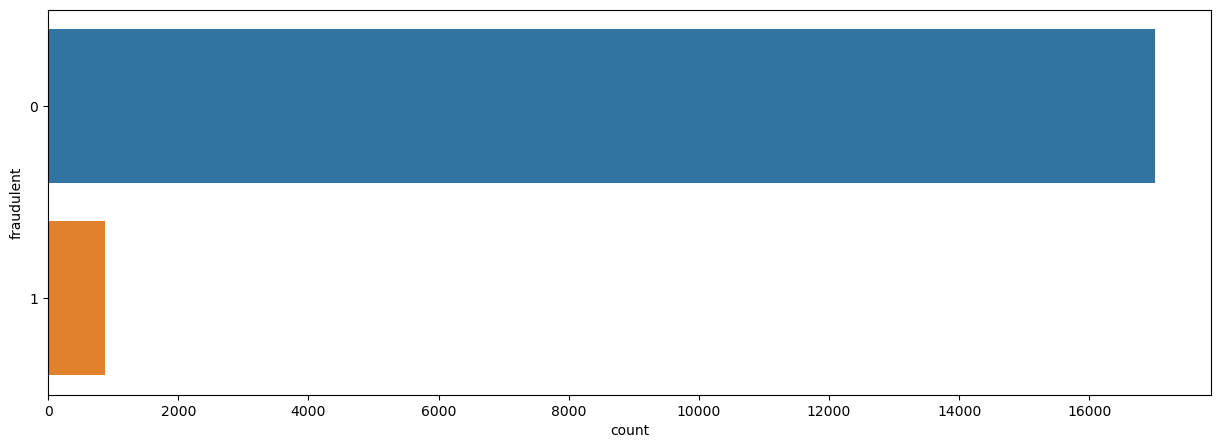

In [157]:
mp.figure(figsize=(15,5))
sns.countplot(y='fraudulent',data=df)
mp.show()

#0-- non frauds whereas 1--fraudulent

In [158]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [159]:
exp=dict(df.required_experience.value_counts())
del exp['']
exp

{'Mid-Senior level': 3809,
 'Entry level': 2697,
 'Associate': 2297,
 'Not Applicable': 1116,
 'Director': 389,
 'Internship': 381,
 'Executive': 141}

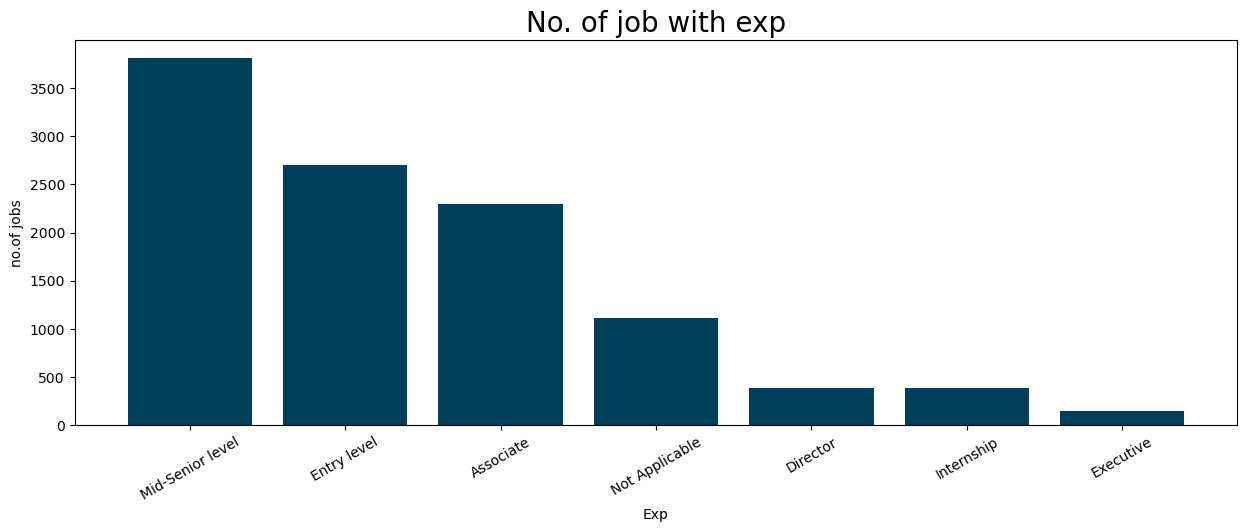

In [192]:
mp.figure(figsize=(15,5))
r='#003f5c'
mp.bar(exp.keys(),exp.values(),color=r)
mp.title("No. of job with exp",size=20)
mp.xlabel("Exp",size=10)
mp.ylabel('no.of jobs',size=10)
mp.xticks(rotation=30)
mp.show()

In [161]:
def createnew_col(location):
    l=location.split(',')
    return l[0]
df['country']=df.location.apply(createnew_col)

In [162]:
df

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0,CA
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0,US
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0,NG


In [163]:
countryy=dict(df.country.value_counts()[:10])
del countryy['']
countryy

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132}

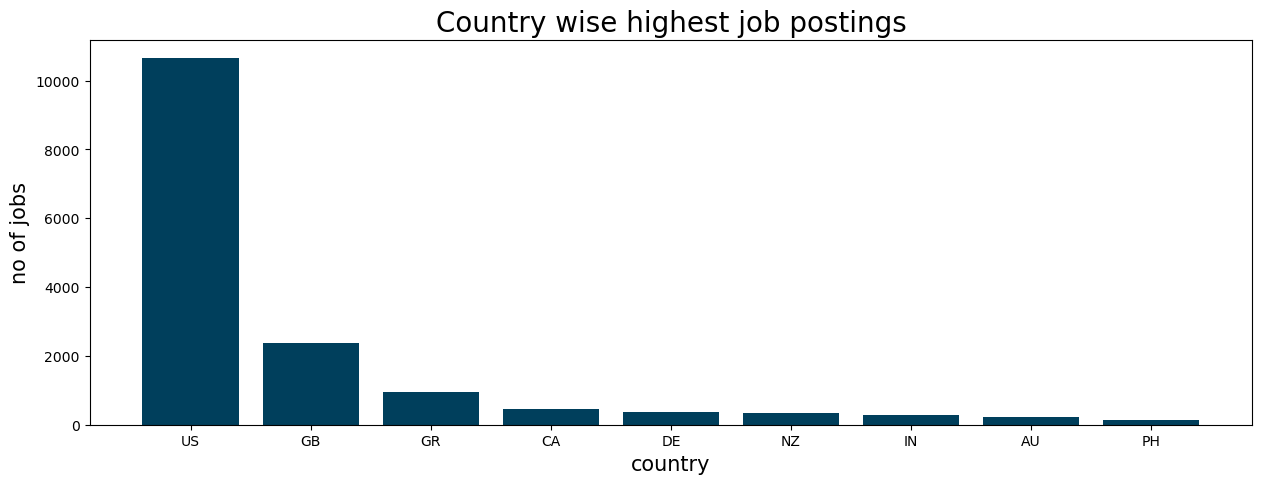

In [193]:
r='#003f5c'
mp.figure(figsize=(15,5))
mp.title('Country wise highest job postings',size=20)
mp.bar(countryy.keys(),countryy.values(),color=r)
mp.ylabel("no of jobs",size=15)
mp.xlabel("country",size=15)
mp.show()

In [165]:
edu=dict(df.required_education.value_counts()[:6])
del edu['']
edu

{"Bachelor's Degree": 5145,
 'High School or equivalent': 2080,
 'Unspecified': 1397,
 "Master's Degree": 416,
 'Associate Degree': 274}

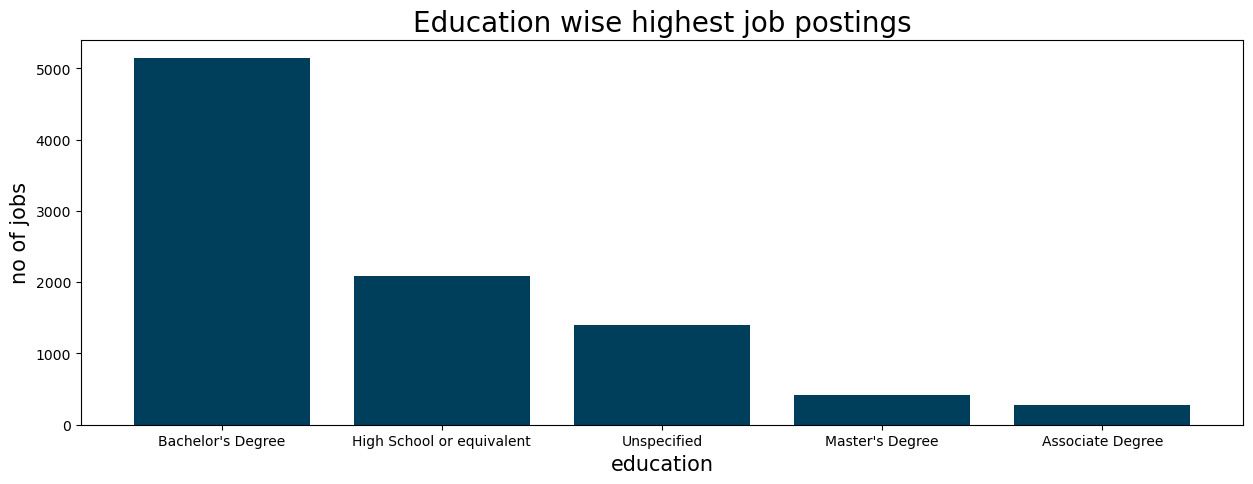

In [194]:
mp.figure(figsize=(15,5))
r='#003f5c'
mp.title('Education wise highest job postings',size=20)
mp.bar(edu.keys(),edu.values(),color=r)
mp.ylabel("no of jobs",size=15)
mp.xlabel("education",size=15)
mp.show()

Working with processed data

In [167]:
print(df[df.fraudulent==0].title.value_counts()[:5])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: title, dtype: int64


In [168]:
print(df[df.fraudulent==1].title.value_counts()[:5])

Data Entry Admin/Clerical Positions - Work From Home               21
Home Based Payroll Typist/Data Entry Clerks Positions Available    21
Cruise Staff Wanted *URGENT*                                       21
Customer Service Representative                                    17
Administrative Assistant                                           16
Name: title, dtype: int64


In [169]:
df['Specification']=df['title']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']

del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']


In [170]:
df

,fraudulent,Specification
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...
...,...,...
17875,0,Account Director - Distribution Vend is looki...
17876,0,Payroll Accountant WebLinc is the e-commerce p...
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,Graphic Designer Nemsia Studios is looking fo...


In [171]:
frauds_spec=df[df.fraudulent==1].Specification
nonfrauds_spec=df[df.fraudulent==0].Specification


Creating WordClouds 

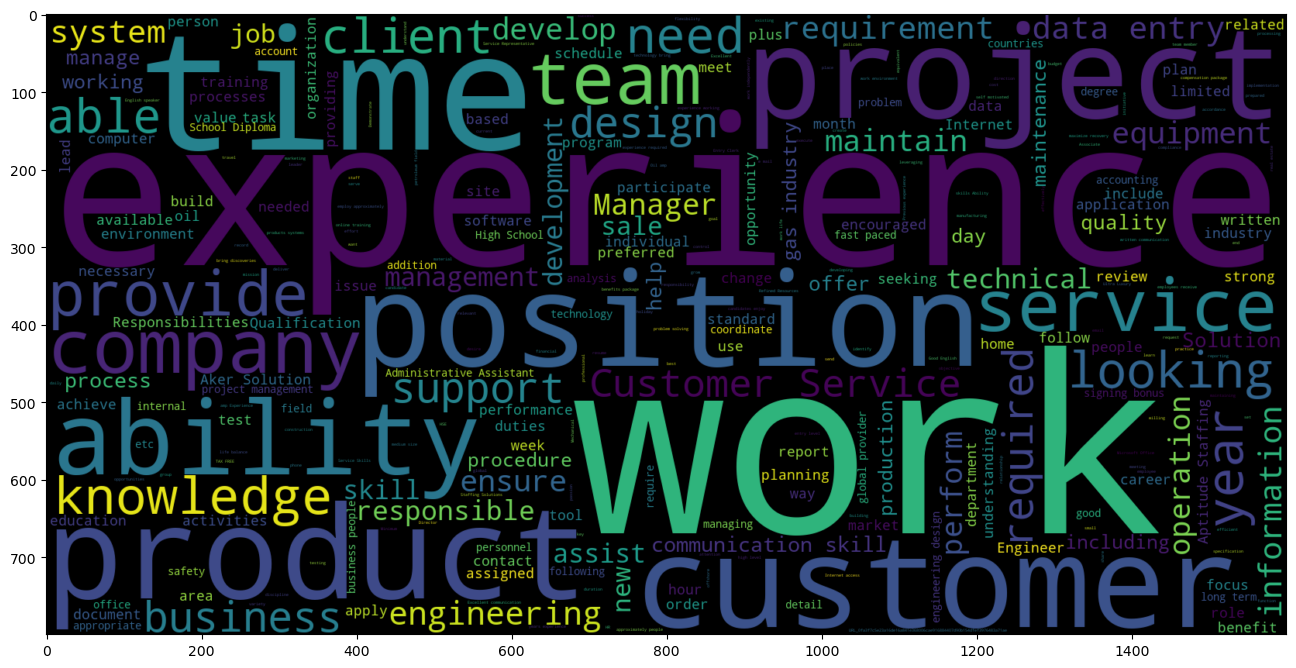

In [172]:
STOPWORDS=spacy.lang.en.stop_words.STOP_WORDS
mp.figure(figsize=(16,14))
words=WordCloud(min_font_size=3,max_words=300,width=1600,height=800,stopwords=STOPWORDS).generate(str("".join(frauds_spec)))
mp.imshow(words,interpolation="bilinear")

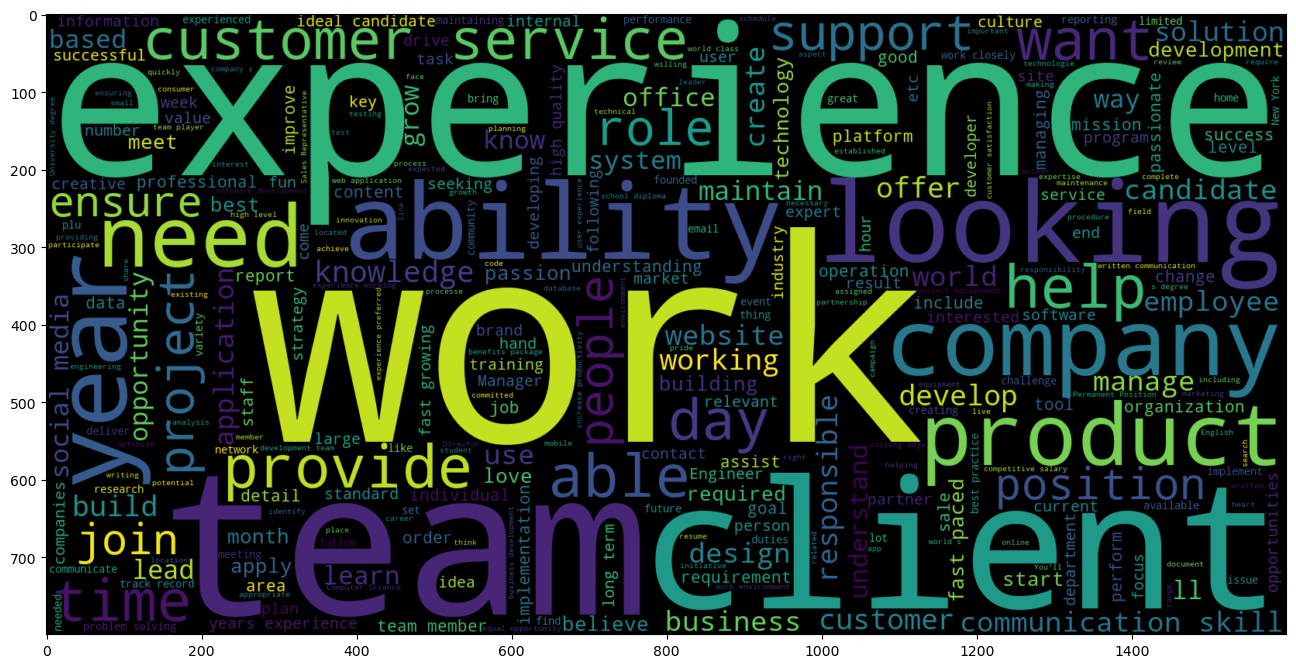

In [173]:
STOPWORDS=spacy.lang.en.stop_words.STOP_WORDS
mp.figure(figsize=(16,14))
words=WordCloud(min_font_size=3,max_words=300,width=1600,height=800,stopwords=STOPWORDS).generate(str("".join(nonfrauds_spec)))
mp.imshow(words,interpolation="bilinear")

valid value for interpolation; supported values are 'antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'


In [174]:
!pip install spacy && python -m spacy download en

     ---------------------------------------- 12.8/12.8 MB 5.5 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [175]:
punc=string.punctuation
nlp=spacy.load("en_core_web_sm")
stop_words=spacy.lang.en.stop_words.STOP_WORDS
parser=English()

def stk(sentence):
    mytokens=parser(sentence)
    mytokens=[word.lemma_.lower().strip() if word.lemma_!="-PRON-" else word.lower_ for word in mytokens]
    mytokens=[word for word in mytokens if word not in stop_words and word not in punc]
    return mytokens


In [176]:
class pred(TransformerMixin):
    def transform(self,X,**transform_params):
        return[clean_text(text)for text in X]
    def fit(self,X,y=None,**fit_params):
        return self
    def get_params(self,deep=True):
        return{}
def clean_text(text):
    return text.strip().lower()

print(df.columns.tolist()) 

In [177]:
df['Specification']=df['Specification'].apply(clean_text)

In [178]:
cv=TfidfVectorizer(max_features=100)
x=cv.fit_transform(df['Specification'])
df1=pd.DataFrame(x.toarray(),columns=cv.get_feature_names_out())
df.drop(["Specification"],axis=1,inplace=True)
dfmain=pd.concat([df1,df],axis=1)

In [179]:
dfmain

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.041120,0.000000,0.042424,0.036488,0.000000,0.755238,0.000000,0.078653,0.000000,...,0.000000,0.000000,0.186067,0.051026,0.068029,0.000000,0.000000,0.000000,0.000000,0
1,0.021895,0.094183,0.035394,0.024292,0.041787,0.029771,0.490896,0.056626,0.060050,0.052431,...,0.000000,0.078004,0.165735,0.043827,0.116862,0.099327,0.000000,0.204854,0.130452,0
2,0.000000,0.000000,0.176807,0.000000,0.041749,0.089231,0.397029,0.113149,0.000000,0.000000,...,0.000000,0.062346,0.307512,0.058383,0.000000,0.000000,0.000000,0.094462,0.074476,0
3,0.023267,0.000000,0.018806,0.000000,0.000000,0.094909,0.695542,0.000000,0.031906,0.037144,...,0.023132,0.049735,0.075480,0.046573,0.000000,0.105551,0.019806,0.050236,0.059411,0
4,0.000000,0.000000,0.068009,0.000000,0.040147,0.028602,0.606379,0.081605,0.115386,0.000000,...,0.000000,0.000000,0.159230,0.028071,0.037425,0.000000,0.035814,0.030279,0.107427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.019816,0.021310,0.080081,0.043970,0.075638,0.040415,0.423122,0.038437,0.013587,0.094904,...,0.059102,0.028239,0.171424,0.158660,0.123392,0.044947,0.000000,0.328016,0.101197,0
17876,0.058329,0.062728,0.094292,0.032358,0.083493,0.019828,0.591619,0.037714,0.000000,0.069840,...,0.000000,0.041562,0.204997,0.116759,0.000000,0.000000,0.049654,0.062971,0.049648,0
17877,0.043011,0.046255,0.000000,0.000000,0.000000,0.029242,0.528094,0.111240,0.058983,0.034333,...,0.000000,0.061294,0.093023,0.057398,0.038262,0.000000,0.073229,0.123824,0.073219,0
17878,0.000000,0.000000,0.061889,0.000000,0.146136,0.052057,0.449624,0.049508,0.000000,0.061120,...,0.076126,0.272793,0.082800,0.051090,0.068115,0.000000,0.000000,0.165325,0.130346,0


Training and Testing the Data

In [180]:
Y = dfmain.iloc[:,-1]
X = dfmain.iloc[:,:-1]

X_train , X_test , y_train , y_test = train_test_split(X,Y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12516, 100)
(12516,)
(5364, 100)
(5364,)


In [181]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion="entropy")
rfc.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_jobs=3, oob_score=True)

In [183]:
pred = rfc.predict(X_test)

In [184]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report\n")
print(classification_report(y_test, pred))

print("Confusion Matrix\n")
print(confusion_matrix(y_test, pred))


Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5108
           1       0.99      0.37      0.54       256

    accuracy                           0.97      5364
   macro avg       0.98      0.69      0.76      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5107    1]
 [ 161   95]]
